# Backpropagation from scratch

Here we're going to implement backpropagation from scratch using only standard Python. We start as simple as defining what a derivative is and work our way up from there.

This notebook loans heavily from Andrej Kaparthys [Spelled-out intro to neural networks and backpropagation](https://www.youtube.com/watch?v=VMj-3S1tku0) video.

### Background

Training a neural network (NN) happens in two steps:

**Forward Propagation**: In forward prop, the NN makes its best guess about the correct output. It runs the input data through each of its functions to make this guess.

**Backward Propagation**: In backprop, the NN adjusts its parameters proportionate to the error in its guess. It does this by traversing backwards from the output, collecting the *derivatives* of the error with respect to the parameters of the functions (gradients), and uses this gradient to adjust its internal values.

By starting this series with implementing backprop we lay the groundwork used to train any NN, regardless of its architecture.
Making it the natural starting point.

In [1]:
# To allow importing modules from nnfs, can be ignored
import sys
import os

# Get the absolute path of the 'src' directory
src_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add 'src' directory to the Python path
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from nnfs.trace_graph import draw_dot  # Must first download graphviz: https://graphviz.org/download/
%matplotlib inline

## Derivatives

A derivative represents the rate at which a function changes. In everyday language, think of it as the "slope" at a particular point. For instance, if you were driving a car and the speedometer reads 60 mph, that's the rate at which your position changes with respect to time. In the world of mathematics, we often talk about the derivative of a function with respect to its variable, like how $f(x)$ changes as $x$ changes.


In [3]:
def f(x):
    return x**3

def slope(x):  # The derivative of f(x)
    return 3*x**2

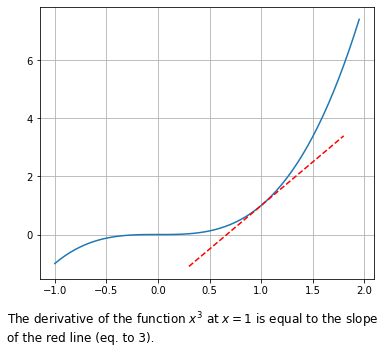

In [4]:
x_range = np.arange(-1, 2, 0.05)
y = f(x_range)

x_tangent = np.linspace(0.3, 1.8, 100)
x1 = 1
y1 = slope(x1)
y_tangent = y1 * (x_tangent - x1) + f(x1)

plt.figure(figsize=(6, 5))
plt.plot(x_range, y)
plt.grid()
plt.plot(x_tangent, y_tangent, 'r--')
plt.figtext(
    0.05, -0.05, 
    'The derivative of the function $x^3$ at $x=1$ is equal to the slope \nof the red line (eq. to 3).', 
    ha="left", fontsize=12)
plt.show()

The derivative of a function $f(x)$ is often denoted by $f'(x)$, or $\frac{dy}{dx}$, if we define $y=f(x)$. To find the derivative, we use the concept of limits. The mathematical definition of the derivative of $f$ at a point $x$ is:

$$\frac{dy}{dx} = \lim_{{h \to 0}} \frac{f(x+h) - f(x)}{h}​$$

Where $\lim_{{h \to 0}}$ means that we want to make the interval $h$ as tiny as possible, or in mathematical terms, we want to make $h$ approach zero.

This formula essentially computes the slope of the function $f$ at the point $x$ by seeing how much $f(x)$ changes (the difference in the function's values) over a tiny interval $h$, and then finding what this rate becomes as that tiny interval $h$ approaches zero. 

We can test this equation by computing the derivative seen in the plot above.

In [5]:
print(f"Numerical approximation of dy/dx of f(x) at x = 1")
x = 1
y = f(x)

h1 = 0.1  # Interval size
dydx1 = (f(x + h1) - f(x)) / h1
print(f'Interval size: {h1} \t dy/dx: {dydx1}')

h2 = 0.01
dydx2 = (f(x + h2) - f(x)) / h2
print(f'Interval size: {h2} \t dy/dx: {dydx2}')

h3 = 0.001
dydx3 = (f(x + h3) - f(x)) / h3
print(f'Interval size: {h3} \t dy/dx: {dydx3}')

h4 = 1e-16
dydx4 = (f(x + h4) - f(x)) / h4
print(f'Interval size: {h4} \t dy/dx: {dydx4}\t\t'
      '<-- Rounding error since h is too small to be properly represented by a float')

Numerical approximation of dy/dx of f(x) at x = 1
Interval size: 0.1 	 dy/dx: 3.310000000000004
Interval size: 0.01 	 dy/dx: 3.0301000000000133
Interval size: 0.001 	 dy/dx: 3.0030009999997276
Interval size: 1e-16 	 dy/dx: 0.0		<-- Rounding error since h is too small to be properly represented by a float


As you can see, as $h$ gets smaller and smaller our approximation gets closer and closer to $\frac{dy}{dx}=3$. 

#### Derivative of a function with multiple inputs

We'll now test something a bit more complex: A function with multiple inputs. 

Let's say we have a function $f(a,\,b,\,c)$. Then the derivatives of the function for the variables $a$, $b$, and $c$ are denoted $\frac{dy}{da}$, $\frac{dy}{db}$, and $\frac{dy}{dc}$. We can take the derivative of each variable by holding the other variables constant. For example, $\frac{dy}{da}$ is the slope of $y$ with respect to $a$ while holding $b$ and $c$ constant. Using the definition of a derivative above we get the following formulas:

$\frac{dy}{da} = \lim_{{h \to 0}} \frac{f(a+h,\,b,\,c) - f(a, b, c)}{h}​$

$\frac{dy}{db} = \lim_{{h \to 0}} \frac{f(a,\,b+h,\,c) - f(a, b, c)}{h}​$

$\frac{dy}{dc} = \lim_{{h \to 0}} \frac{f(a,\,b,\,c+h) - f(a, b, c)}{h}​$

Let's see this in action in code:

In [6]:
def f(a, b, c):
    return a * b + c

a = 5
b = 2
c = -3
fx = f(a, b, c)  # 5 * 2 - 3 = 7

We'll start with $\frac{dy}{da}$. 

Intuitively, we can think of it as the slope of the function $y$ with respect to $a$. I.e. how much does $y$ change when $a$ changes by a tiny bit. This should be simple to reason about in the case of $a*b + c$: If $a$ increases by a tiny bit, we can see that $a*b + c$ will increase proportionally by $b$. So we get $\frac{dy}{da} = b = 2$, which can be verified numerically.

In [7]:
h = 0.001
dy_da = (f(a+h, b, c) - f(a, b, c))/h
dy_da

2.000000000000668

The same line of thought can be extended to $b$ and $c$ as well. Increasing $b$ a tiny bit should increas $a*b + c$ proportionally by $a$ (i.e. $5$), while increasing $c$ a tiny bit should increase $a*b + c$ by $1$.

In [8]:
dy_db = (f(a, b+h, c) - f(a, b, c))/h
print(dy_db)

dy_dc = (f(a, b, c+h) - f(a, b, c))/h
print(dy_dc)

4.999999999999005
0.9999999999994458


Taking the derivative of a function with multiple variables by holding the other variables constant is called a partial derivative.

### The Value object - Part I

Neural networks will usually be pretty massive expressions. So we'll need a data structure that maintains the expression tree and allows us to compute the gradients of the expression with respect to its inputs. We'll call this data structure a `Value` object.

We'll implement it in iterations to get a better understanding of what it does. In this first iteration, we'll just implement a object that holds a single value, print it, and do basic arithmetic with it.

In [9]:
class Value:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__ (self, other):
        out = Value(self.data + other.data)
        return out
    
    def __mul__ (self, other):
        out = Value(self.data * other.data)
        return out
    
    def __pow__ (self, other):
        out = Value(self.data ** other.data)
        return out

    def __neg__(self):
        return self * -1

In [10]:
def f(a, b, c):
    return a * b + c

a = Value(5)
b = Value(2)
c = Value(-3)

y = f(a, b, c)
y

Value(7)

A pretty simple data structure so far.
The next step is to add the expression tree to our data structure so that we can keep track of what expressions produced what value.

In [11]:
class Value:
    def __init__(self, data):
        self.data = data
        self._children = set()
        self._operator = ''
        self.grad = 0  # Implemented later, ignore for now
        
    @classmethod
    def _from_operation(cls, data, children, operator):
        # Creates a new Value object from an operation and 
        # # stores the children and operator used to produce it.
        out = cls(data)
        out._children = set(children)
        out._operator = operator
        return out

    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__ (self, other):
        out = Value._from_operation(self.data + other.data, (self, other), '+')
        return out

    def __sub__ (self, other):
        out = Value._from_operation(self.data - other.data, (self, other), '-')
        return out
    
    def __mul__ (self, other):
        out = Value._from_operation(self.data * other.data, (self, other), '*')
        return out
    
    def __pow__ (self, other):
        out = Value._from_operation(self.data ** other.data, (self, other), '**')
        return out

    def __neg__(self):
        return self * -1

In [12]:
def f(a, b, c):
    return a * b + c

a = Value(5)
b = Value(2)
c = Value(-3)

y = f(a, b, c)
print(y)
print(y._children)  # = {Value(a*b), c} since + is applied last 
print(y._operator)

Value(7)
{Value(-3), Value(10)}
+


This data structure works recursively. So if `y`'s children has any children of their own, they can be accessed through the `y._children` attribute. With this recursiveness we have a data structure able to store any expression.

To view these expressions we can use the `draw_dot` function (imported at the start).

(The implementation of `draw_dot` is not important for understanding the contents of the notebook, so we will not go into it.)

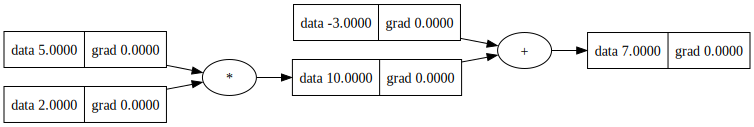

In [13]:
draw_dot(y)

Just ignore the *grad* part of each node for now.
What you see is a graph representation of our expression $2*5 - 3$ used to produce $y=7$.

We now have a data structure that represents any expression using the arithmetic we so far has implemented.

### Chain Rule and Backpropagation

Let's start this section with a simple example, $y = (a \times b + c) \times f$:

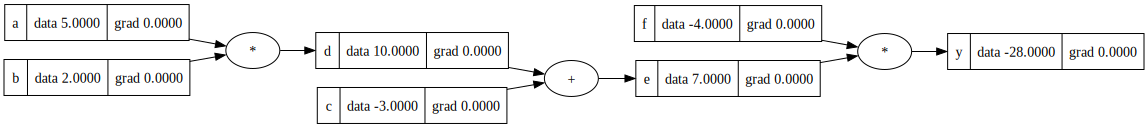

In [14]:
a = Value(5); a.label = 'a'
b = Value(2); b.label = 'b'
c = Value(-3); c.label = 'c'
f = Value(-4); f.label = 'f'

d = a * b; d.label = 'd'
e = d + c; e.label = 'e'
y = e * f; y.label = 'y'

draw_dot(y)

I've given each node a label so that we can refer to them more easily.

What we want to accomplish here is to compute the gradient (derivative) of each variable in this expression. I.e., we want to find how a tiny change in each variable would affect the output $y$.

We'll do this by filling in the values right to left. The first step is simple. We start with the derivatives $\frac{dy}{dy}$, $\frac{dy}{de}$ and $\frac{dy}{df}$.

Remember that the definition of the derivative is:

$\frac{dy}{dx} = \lim_{h \to 0} \frac{f(x + h) - f(x)}{h}$

In [15]:
h = Value(0.0001)

dy_dy = 1  # dy/dy is always equal to 1, naturally
dy_de = (((e + h) * f) - (e * f)).data / h.data
dy_df = ((e * (f + h)) - (e * f)).data / h.data

print(dy_de, dy_df)

-3.9999999999906777 7.000000000019213


As expected. Increasing $e$ a tiny bit should increase $y$ proportionally with $f$, and vice versa for increasing $f$.

Let's update our graph with our new values.

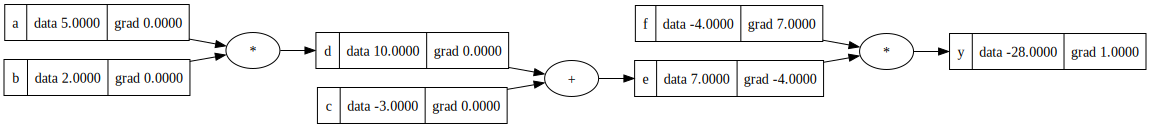

In [16]:
y.grad = dy_dy
e.grad = dy_de
f.grad = dy_df
draw_dot(y)

The next step is to compute the derivatives $\frac{dy}{dc}$ and $\frac{dy}{dd}$. We've did something similar above when we computed the partial derivatives of $y = a*b + c$, but we'll take a slightly different approach here.

You see, we can use what we already know, that $\frac{dy}{de}=-4$, and something called the chain rule to compute $\frac{dy}{dc}$ and $\frac{dy}{dd}$.

The chain rule says that:

$$\frac{dy}{dx} = \frac{dy}{du}\times \frac{du}{dx}$$

We will not go into proving the chain rule here. But will instead give an short explanation. 

The chain rule states that knowing the rate of change of $y$ relative to $u$ and that of $u$ relative to $x$ allows one to calculate the rate of change of $y$ relative to $x$ as the product of the two rates of change. As put by George F. Simmons: *"If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man"*. [[1]](https://en.wikipedia.org/wiki/Chain_rule)

So, for our problem, we can use the chain rule to compute:

$\frac{dy}{dc} = \frac{dy}{de}\times \frac{de}{dc} = -4\times \frac{de}{dc}$

$\frac{dy}{dd} = \frac{dy}{de}\times \frac{de}{dd} = -4\times \frac{de}{dd}$

We just need to find $\frac{de}{dc}$ and $\frac{de}{dd}$.

In [17]:
# Remember that e = c + d

de_dc = (((c + h) + d) - (c + d)).data / h.data
de_dd = ((c + (d + h)) - (c + d)).data / h.data
print(de_dc, de_dd)

0.9999999999976694 0.9999999999976694


Both gradients are equal to one, which is always the case when we take the derivative of an addition.

Now we can plug this into the formulas above:

$\frac{dy}{dc} = -4\times \frac{de}{dc} = -4\times1=-4$

$\frac{dy}{dd} = -4\times \frac{de}{dd} = -4\times1=-4$

This can be verified computationally without using the chain rule.

In [18]:
dy_dc = (((c + h) + d)*f - (c + d)*f).data / h.data
dy_dd = ((c + (d + h))*f - (c + d)*f).data / h.data
print(dy_dc, dy_dd)

-3.9999999999906777 -3.9999999999906777


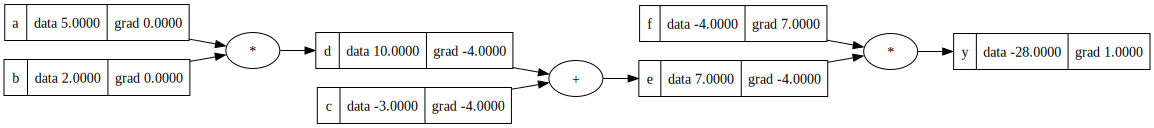

In [19]:
c.grad = dy_dc
d.grad = dy_dd
draw_dot(y)

We can use the same method to find the derivatives $\frac{dy}{da}$ and $\frac{dy}{db}$.

$\frac{dy}{da} = \frac{dy}{de}\times \frac{de}{dd} \times \frac{dd}{da} = -4\times \frac{dd}{da}$

$\frac{dy}{db} = \frac{dy}{de}\times \frac{de}{dd} \times \frac{dd}{db} = -4\times \frac{dd}{db}$

In [20]:
# d = a * b
dd_da = ((a + h)*b - a*b).data / h.data
dd_db = (a*(b + h) - a*b).data / h.data
print(dd_da, dd_db)

1.9999999999953388 5.000000000006111


$\frac{dy}{da} = -4\times 2 = -8$ 

$\frac{dy}{db} = -4\times 5 = -20$

Which again can be verified computationally:

In [21]:
# I'll define a function to make the expression easier to read
def expr(a, b, c, f):
    return (a * b + c) * f

dy_da = (expr(a + h, b, c, f) - expr(a, b, c, f)).data / h.data
dy_db = (expr(a, b + h, c, f) - expr(a, b, c, f)).data / h.data
print(dy_da, dy_db)

-7.999999999981355 -20.000000000024443


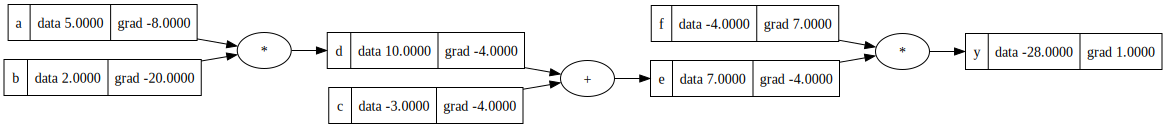

In [22]:
a.grad = dy_da
b.grad = dy_db
draw_dot(y)

That's it! What we've done now is essentially back-propagation by hand. Backprop is just a recursive application of chain rule backwards through the computation graph. We've done it by hand for a simple example, but the same process can be applied to any computation graph.

#### Preview of a simple optimization step

Before we continue, we'll motivate our approach by showing a simple optimization step. We can pretend that our expression is a model prediction and that the true value is -30. We can use our gradients to nudge our inputs in the direction of the true value, meaning in this case decreasing our values towards -30.

In [23]:
# We'll do just a small nudge, -0.003 times the gradient
a.data += -0.003 * a.grad
b.data += -0.003 * b.grad
c.data += -0.003 * c.grad
f.data += -0.003 * f.grad

# Let's remove our old gradients, since they're no longer the same
a.grad, b.grad, c.grad, f.grad = 0, 0, 0, 0

The size of the nudge is in Deep Learning literature called the *learning rate*. We can now update our expression with the new values and see what its output $y$ is.

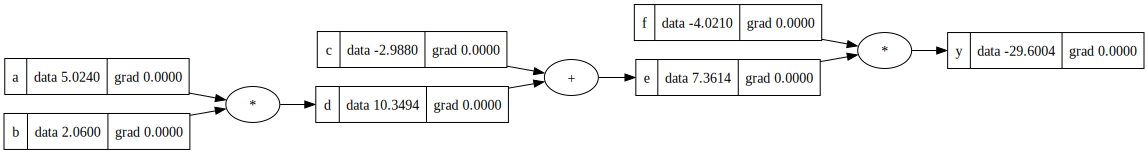

In [24]:
d = a * b; d.label = 'd';
e = c + d; e.label = 'e'
y = e * f; y.label = 'y'
draw_dot(y)

We've successfully nudged our expression towards the pretend "true value"!